# python launcher

In [1]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'intermodal'
    %matplotlib inline

In [2]:
#%matplotlib inline

In [3]:
import pandas as pd

# import 

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np

work_path = r'../../../'
quetzal_path = work_path + r'quetzal_santo_domingo/'

import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel
from quetzal.io import display

SQLalchemy is not installed. No support for SQL output.


In [5]:
distributed =  stepmodel.read_zip(quetzal_path + 'model/transport/distribution.zip')

zones: 100%|██████████| 29/29 [00:00<00:00, 121.84it/s]                    


In [6]:
car =  stepmodel.read_zip(quetzal_path + 'model/transport/car_pathfinder.zip')
pt = stepmodel.read_zip(quetzal_path + 'model/'+ scenario +'/pt_pathfinder.zip')

zones: 100%|██████████| 26/26 [00:02<00:00,  9.55it/s]          


In [7]:
sm = pt.copy()
sm.car_los = car.car_los

sm.road_nodes = car.road_nodes
sm.road_links = car.road_links

In [8]:
sm.volumes = distributed.volumes

# prep

In [9]:
self = sm
for value in ['length']:
    value_dict = self.road_links[value].to_dict()
    self.car_los[value] = self.car_los['link_path'].apply(
        lambda p: sum([value_dict[l] for l in p])
    ) 

# Utility parameters

In [10]:
parameter_frame = pd.read_excel(quetzal_path + r'inputs/parametros.xlsx').set_index(['category','parameter'])
for c in parameter_frame.columns:
    parent = parameter_frame[c][('general', 'parent')]
    try:
        parent = parent.iloc[0]
    except AttributeError:# 'str' object has no attribute 'iloc'
        pass
    parameter_frame[c] = parameter_frame[c].fillna(parameter_frame[parent])
var = parameter_frame[scenario]

year = int(var['general', 'year'])

In [11]:
var

category                 parameter          
PARAMETROS DE ESCENARIO  NaN                                  NaN
general                  parent                 ambicioso_sitp_30
                         year                                2030
                         freeze_modal_split                 false
                         freeze_distribution                false
                                                      ...        
                         footpath_speed                       3.4
                         short_leg_speed                      4.4
                         long_leg_speed                        12
                         n_ntlegs                              10
                         ntleg_threshold                      300
Name: intermodal, Length: 115, dtype: object

# volumes

In [12]:
if var['general','freeze_distribution'].iloc[0].lower() == 'true':
    sm.volumes['car'] = sm.volumes['survey_car']
    sm.volumes['nocar'] = sm.volumes['survey_pt'] + sm.volumes['survey_walk']
    delta = year - 2018
    for segment in ['car', 'nocar']:
        sm.volumes[segment] = sm.volumes[segment]  * np.power(sm.volumes['growth'], delta)
else :
    sm.volumes[['car', 'nocar']] = sm.volumes[['car' + str(year), 'nocar' + str(year)]]

In [13]:
car_speed = float(var['speed']['car'])
gas_per_km = float(var['general']['gas_per_km']) # gal US per km (1 US gal= 3.7L)
gas_price = float(var['general']['gas_price'])# DOP per gal US
price_per_m =  gas_per_km * gas_price / 1000

# Fares

## PT fares

In [14]:
fare_attributes = pd.DataFrame(
    {
    'price': var['price'],
    'transfers': var['transfers']
    }
)
fare_attributes.index.name = 'fare_id'
fare_attributes.reset_index(inplace=True)
fare_attributes[['price', 'transfers']] = fare_attributes[['price', 'transfers']].astype(float)
fare_attributes.loc[fare_attributes['fare_id'] == 'integrated', 'transfers'] = np.inf

# CHANGE TO TRUE TO TEST FARES | FALSE FOR THE FORMER BEHAVIOUR
add_custom_fare_attributes = False
#TODO change that so it is automated somehow
if add_custom_fare_attributes:
    fare_attributes = fare_attributes.append(pd.Series({'fare_id': 'direct', 'price': 25, 'transfers': 0}), ignore_index=True)
    fare_attributes = fare_attributes.append(pd.Series({'fare_id': 'opret', 'price': 20, 'transfers': np.inf}), ignore_index=True)
fare_attributes

,fare_id,price,transfers
0,bus,15.0,0.0
1,concho,25.0,0.0
2,express_bus,30.0,0.0
3,f0,25.0,0.0
4,f1,40.0,1.0
5,f2,55.0,2.0
6,f3,70.0,3.0
7,fn,80.0,10.0
8,integrated,50.0,inf
9,minibus,25.0,0.0


In [15]:
left = left = var['fare_id'].apply(lambda s: [item.strip() for item in  s.split(',')]).explode().reset_index()
left.columns = ['route_type', 'fare_id']

#TODO change that so it is automated somehow
if add_custom_fare_attributes:
    left = pd.concat(
        [
            left, 
            left.loc[left['fare_id']=='integrated'].replace('integrated', 'direct'),
            left.loc[left['route_type'].isin(['subway'])].replace('integrated', 'opret')
        ]
    )


In [16]:
right = pt.lines[['route_type', 'route_id']]

In [17]:
fare_rules = pd.merge(left, right)[['fare_id', 'route_id']]
fare_rules.head()

,fare_id,route_id
0,concho,CP_C100_1
1,concho,CP_C100_2
2,concho,CP_C101E_1
3,concho,CP_C101E_2
4,concho,CP_C102_1


In [18]:
fare_attributes['agency_id'] = 'intrant'

In [19]:
sm.links['agency_id'] = 'intrant'
sm.nodes['zone_id'] = 0

In [20]:
sm.fare_rules = fare_rules
sm.fare_attributes = fare_attributes
sm.compute_arod_list()


In [21]:
# FORMER FARES
# sm.analysis_pt_fare(od_fares=False) 

# TEST

In [22]:
forbidden = {
    'f0': {'f1', 'f2', 'f3', 'f4', 'f5'},
    'f1': {'f0', 'f2', 'f3', 'f4', 'f5'},
    'f2': {'f0', 'f1', 'f3', 'f4', 'f5'},
    'f3': {'f0', 'f1', 'f2', 'f4', 'f5'},
    'f4': {'f0', 'f1', 'f2', 'f3', 'f5'},
    'f5': {'f0', 'f1', 'f2', 'f3', 'f4'},
} # fares that are irrelevant when consecutive

In [23]:
# NEW FARES
from quetzal.engine import fares
from imp import reload
reload(fares)
def compute_route_fares(self, consecutive=False):
    transfers = self.fare_attributes.set_index('fare_id')['transfers'].to_dict()
    price = self.fare_attributes.set_index('fare_id')['price'].to_dict()
    route_fares_dict = self.fare_rules.groupby('route_id')['fare_id'].agg(frozenset).to_dict()
    fare_options = [fares.get_fare_options(arod_list, route_fares_dict) for arod_list in sm.pt_los['arod_list']]
    unique_fare_options = set(fare_options)
    print(len(unique_fare_options))
    cheapest_breakdown_dict = {
        fo : fares.get_cheapest_breakdown(
            fares.get_breakdown_options(fo, transfers, price, forbidden=forbidden)
        )
        for fo in unique_fare_options
    }
    self.pt_los['route_fares'] = [cheapest_breakdown_dict[fo] for fo in fare_options]
    
compute_route_fares(sm)
sm.pt_los['price'] = sm.pt_los['route_fares'].apply(lambda breakdown: sum(breakdown.values()))

380


In [24]:
sm.pt_los[['route_fares', 'price']]

,route_fares,price
0,{},0.0
1,{},0.0
2,{},0.0
3,{},0.0
4,{},0.0
...,...,...
15520,"{'opret': 20.0, 'bus': 15.0}",35.0
48,"{'opret': 20.0, 'bus': 15.0}",35.0
80,"{'bus': 30.0, 'opret': 20.0}",50.0
81,"{'bus': 30.0, 'opret': 20.0}",50.0


## car fares

In [25]:
# length
self = sm
sm.road_links['toll'] = 0

In [26]:
self.car_los['price'] = self.car_los['length'] * price_per_m #+ self.car_los['toll']

# Time

## walk_time

In [27]:
short_leg_speed = float(var['general']['short_leg_speed'])
long_leg_speed = float(var['general']['long_leg_speed'])
threshold= float(var['general']['ntleg_threshold'])
footpath_speed= float(var['general']['footpath_speed'])
n_ntlegs = int(var['general']['n_ntlegs'])

In [28]:
sm.footpaths['time'] = sm.footpaths['length']  / 1000 * 3600 / footpath_speed
#sm.zone_to_transit['time'] = sm.zone_to_transit['distance']  / 1000 * 3600 / short_leg_speed
#sm.zone_to_road['time'] = sm.zone_to_road['distance']  / 1000 * 3600 / short_leg_speed

In [29]:
sm.preparation_ntlegs(
    n_ntlegs=n_ntlegs,
    short_leg_speed=short_leg_speed,
    long_leg_speed=long_leg_speed,
    zone_to_road=True,
)

## car_time

In [30]:
sm.road_links['speed'] = car_speed
sm.road_links['time'] = sm.road_links['length'] / 1000 * 3600 / sm.road_links['speed']

In [31]:
sm.zone_to_road  = car.zone_to_road

In [32]:
sm.analysis_car_time()
sm.analysis_car_length()

## pt_time

In [33]:
from shapely import geometry
def straight_length(ls):
    return geometry.LineString([list(ls.coords)[0],  list(ls.coords)[-1]]).length

In [34]:
sm.links['length'] = sm.links['geometry'].apply(straight_length)

In [35]:
if False:
    sm.links['speed'] = link_speed
    sm.links.loc[sm.links['route_type'] == 'subway', 'speed'] = metro_speed
    sm.links['time'] =  sm.links['length'] / 1000 * 3600 / sm.links['speed']

In [36]:
sm.analysis_pt_time(boarding_time=0)
sm.analysis_pt_length()

# transfers

In [37]:
sm.car_los['ntransfers'] = 0
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(len)

# route_types

In [38]:
mode_hierarchy = ['car', 'subway', 'tram',  'gondola', 'express_bus', 'bus', 'minibus', 'concho', 'walk']

In [39]:
sm.los = sm.pt_los
sm.analysis_pt_route_type(hierarchy=mode_hierarchy)
sm.analysis_car_route_type()

In [40]:
sm.lighten_pt_los()
sm.analysis_pt_los()
sm.lighten_car_los()
sm.analysis_car_los()
sm.los = pd.concat([sm.car_los, sm.pt_los]).reset_index(drop=True)

path_analysis: 100%|██████████| 123569/123569 [00:03<00:00, 34228.59it/s]


In [41]:
#sm.los.dropna(axis=1, inplace=True)

# UTILITY

In [42]:
loc = (sm.los['route_type'] == 'walk') & (sm.los['time'] > 1800)
sm.los.loc[loc, 'price'] = 100

In [43]:
route_types = set(sm.links['route_type'].unique()).union({'car', 'walk'})

In [44]:
# Average
sm.preparation_logit(
    mode=1, 
    pt_mode=0.5, 
    pt_path=0.2, 
    time=-1 / 3600,
    price= -1 / 50,
    transfers=-0.2,
    segments=['car', 'nocar'],
)

In [45]:
sm.mode_utility[['car', 'nocar']] = 0
sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 0.5] # [-100, 0] 
sm.mode_utility.loc[['minibus', 'concho'], ['nocar', 'car']] = 0

if var['general','freeze_modal_split'].iloc[0].lower() == 'true':
    sm.mode_utility.loc[['car'], ['nocar', 'car']] = [-100, 100] # [-100, 0] 

In [46]:
sm.mode_utility -= sm.mode_utility.max()

In [47]:
sm.logit_scales
sm.mode_utility

segment,root,car,nocar
route_type,,,
express_bus,0.0,-0.5,0.0
subway,0.0,-0.5,0.0
car,0.0,0.0,-100.0
concho,0.0,-0.5,0.0
root,0.0,-0.5,0.0
minibus,0.0,-0.5,0.0
walk,0.0,-0.5,0.0
bus,0.0,-0.5,0.0
gondola,0.0,-0.5,0.0


In [48]:
sm.utility_values.loc['time', 'car'] = sm.utility_values.loc['time', 'nocar'] * 2

# here

In [49]:
sm.los.reset_index(drop=True, inplace=True)

In [50]:
sm.los['index'] = sm.los.index

# utility

In [51]:
sm.analysis_mode_utility(how='min', segment='car')
sm.analysis_mode_utility(how='min', segment='nocar')

In [52]:
sm.initialize_logit()

In [53]:
sm.segments = ['car', 'nocar']

In [54]:
sm.logit_scales['nocar'] = sm.logit_scales['car']

In [55]:
sm.logit_scales

segment,root,car,nocar
route_type,,,
express_bus,0.2,0.2,0.2
subway,0.2,0.2,0.2
car,0.0,0.0,0.0
concho,0.2,0.2,0.2
root,1.0,1.0,1.0
minibus,0.2,0.2,0.2
walk,0.0,0.0,0.0
bus,0.2,0.2,0.2
gondola,0.2,0.2,0.2


In [56]:
sm.step_logit(nchunks=5)

100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


In [57]:
sm.od_probabilities = sm.probabilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')
sm.od_utilities = sm.utilities.set_index(
    ['origin', 'destination', 'segment']
).unstack('segment').swaplevel(axis='columns')

In [58]:
sm.od_probabilities

segment              car nocar       car     nocar       car         nocar  \
route_type          root  root      walk      walk       car           car   
origin  destination                                                          
zone_1  zone_1         1     1  0.500000  1.000000  0.500000  3.720076e-44   
        zone_10        1     1  0.006519  0.032299  0.433854  1.717682e-44   
        zone_101       1     1  0.000010  0.001229  0.056838  2.800131e-45   
        zone_102       1     1  0.002345  0.020208  0.414243  1.590041e-44   
        zone_103       1     1  0.011244  0.038940  0.435254  1.612630e-44   
...                  ...   ...       ...       ...       ...           ...   
zone_98 zone_94        1     1  0.485450  0.640788  0.366359  1.695751e-44   
        zone_95        1     1  0.028130  0.064883  0.553563  2.195233e-44   
        zone_96        1     1  0.030166  0.094206  0.668845  3.228794e-44   
        zone_97        1     1  0.038253  0.105705  0.721184  4.060971e-44   
        zone_98        1     1  0.500000  1.000000  0.500000  3.720076e-44   

segment                   car     nocar       car     nocar  ...  car nocar  \
route_type                 pt        pt      tram      tram  ...  bus   bus   
origin  destination                                          ...              
zone_1  zone_1       0.000000  0.000000  0.000000  0.000000  ...  0.0   0.0   
        zone_10      0.559627  0.967701  0.000000  0.000000  ...  0.0   0.0   
        zone_101     0.943152  0.998771  0.007899  0.029298  ...  0.0   0.0   
        zone_102     0.583412  0.979792  0.000000  0.000000  ...  0.0   0.0   
        zone_103     0.553502  0.961060  0.000000  0.000000  ...  0.0   0.0   
...                       ...       ...       ...       ...  ...  ...   ...   
zone_98 zone_94      0.148191  0.359212  0.122516  0.287086  ...  0.0   0.0   
        zone_95      0.418308  0.935117  0.000000  0.000000  ...  0.0   0.0   
        zone_96      0.300989  0.905794  0.000000  0.000000  ...  0.0   0.0   
        zone_97      0.240564  0.894295  0.087480  0.386934  ...  0.0   0.0   
        zone_98      0.000000  0.000000  0.000000  0.000000  ...  0.0   0.0   

segment                   car     nocar       car     nocar       car  \
route_type            minibus   minibus    concho    concho    subway   
origin  destination                                                     
zone_1  zone_1       0.000000  0.000000  0.000000  0.000000  0.000000   
        zone_10      0.031778  0.092914  0.001096  0.003706  0.338578   
        zone_101     0.000852  0.009038  0.000160  0.001697  0.934240   
        zone_102     0.021240  0.072587  0.009125  0.027140  0.404577   
        zone_103     0.087929  0.228743  0.023431  0.058637  0.257247   
...                       ...       ...       ...       ...       ...   
zone_98 zone_94      0.000000  0.000000  0.025675  0.072126  0.000000   
        zone_95      0.096759  0.237911  0.103395  0.245934  0.015661   
        zone_96      0.038306  0.127969  0.050726  0.147262  0.030837   
        zone_97      0.142468  0.446797  0.010615  0.060564  0.000000   
        zone_98      0.000000  0.000000  0.000000  0.000000  0.000000   

segment                 nocar         car       nocar  
route_type             subway express_bus express_bus  
origin  destination                                    
zone_1  zone_1       0.000000    0.000000    0.000000  
        zone_10      0.512306    0.000000    0.000000  
        zone_101     0.958740    0.000000    0.000000  
        zone_102     0.593766    0.000000    0.000000  
        zone_103     0.373546    0.000000    0.000000  
...                       ...         ...         ...  
zone_98 zone_94      0.000000    0.000000    0.000000  
        zone_95      0.070908    0.202492    0.380365  
        zone_96      0.171287    0.181120    0.459275  
        zone_97      0.000000    0.000000    0.000000  
        zone_98      0.000000    0.000000    0.00

In [59]:
t = sm.los['path'].apply(tuple)

# Control

In [60]:
if manual:
    %matplotlib inline

In [61]:
sm.volumes = distributed.volumes.copy()
#sm.volumes.loc[sm.volumes['origin'] == sm.volumes['destination'], ['car', 'nocar']] = 0 

In [62]:
sm.od = sm.volumes.set_index(['origin', 'destination'])[['car', 'nocar']] 

In [63]:
sm.probabilities

route_type,origin,destination,segment,root,walk,car,pt,tram,gondola,bus,minibus,concho,subway,express_bus
0,zone_107,zone_1,car,1,0.416109,3.780582e-01,0.205833,0.000000,0.000000,0.000000,0.099487,0.106346,0.000000,0.000000
1,zone_107,zone_1,nocar,1,0.544562,1.694970e-44,0.455438,0.000000,0.000000,0.000000,0.223924,0.231514,0.000000,0.000000
2,zone_107,zone_10,car,1,0.014253,4.281614e-01,0.557585,0.000000,0.316227,0.000000,0.029218,0.005426,0.206714,0.000000
3,zone_107,zone_10,nocar,1,0.045992,1.705811e-44,0.954008,0.000000,0.501656,0.000000,0.083658,0.015591,0.353103,0.000000
4,zone_107,zone_101,car,1,0.000009,5.844347e-02,0.941547,0.003057,0.000000,0.000000,0.004014,0.000215,0.934261,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,zone_92,zone_96,nocar,1,0.076901,3.372863e-44,0.923099,0.000000,0.000000,0.851311,0.012612,0.059176,0.000000,0.000000
6246,zone_92,zone_97,car,1,0.109855,8.168016e-01,0.073343,0.021574,0.000000,0.036114,0.012014,0.003642,0.000000,0.000000
6247,zone_92,zone_97,nocar,1,0.275802,6.119165e-44,0.724198,0.126274,0.000000,0.510139,0.059313,0.028473,0.000000,0.000000
6248,zone_92,zone_98,car,1,0.028853,5.685876e-01,0.402559,0.326389,0.000000,0.000000,0.028498,0.032852,0.000000,0.014820


In [64]:
a = sm.od_probabilities.copy()
a.columns = pd.MultiIndex.from_tuples(a.columns)

In [65]:
voy = a['car'].apply(lambda c: c * sm.od['car']) + a['nocar'].apply(lambda c: c * sm.od['nocar']) 

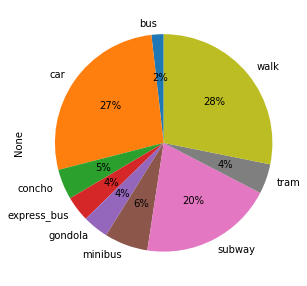

In [66]:
voykil = voy.apply(
    lambda c: c * distributed.euclidean.set_index(
    ['origin', 'destination']).sort_index()['km']
)


s = voy.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

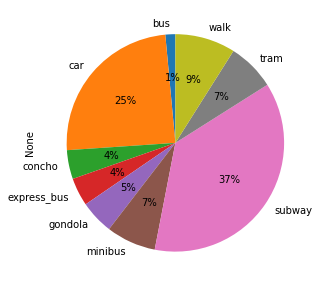

In [67]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]
plot = s.plot(
    kind='pie', 
    autopct='%1.0f%%',
    shadow=False,
    startangle=90, figsize=[5, 5])
plot.set_aspect('equal')

In [68]:
s = voykil.sum()[sorted(set(sm.mode_nests.index) - set(sm.mode_nests['root']))]

# Assignment

In [69]:
sm.car_los['path'] = sm.car_los['path'].apply(tuple)
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.los['path'] = sm.los['path'].apply(tuple)

## PT

# segmented assignment

In [70]:
sm.step_assignment(boarding_links=True, alightings=True, transfers=True, road=True, segmented=False)

In [71]:
sm.road_links.loc[53982]

index                                                        53982
a                                              osm_node_1864096701
b                                              osm_node_2295336584
length                                                   47.330829
geometry         LINESTRING (393513.6355091452 2047148.77479883...
capacity                                                      5000
time                                                     14.199249
toll                                                             0
speed                                                         12.0
(volume, car)                                             5.700228
(volume, pt)                                            335.284777
Name: 53982, dtype: object

In [72]:
links = sm.links#.loc[sm.links['route_type'] == 'subway']
links = sm.links.loc[sm.links['volume'] > 0]
links['label'] = ''

In [73]:
links['volume'].max()

16181.07263111303

In [74]:
sm.road_links['volume'] = sm.road_links[('volume', 'pt')]

In [75]:
df = sm.links
df = df.loc[df['volume'] > 0]

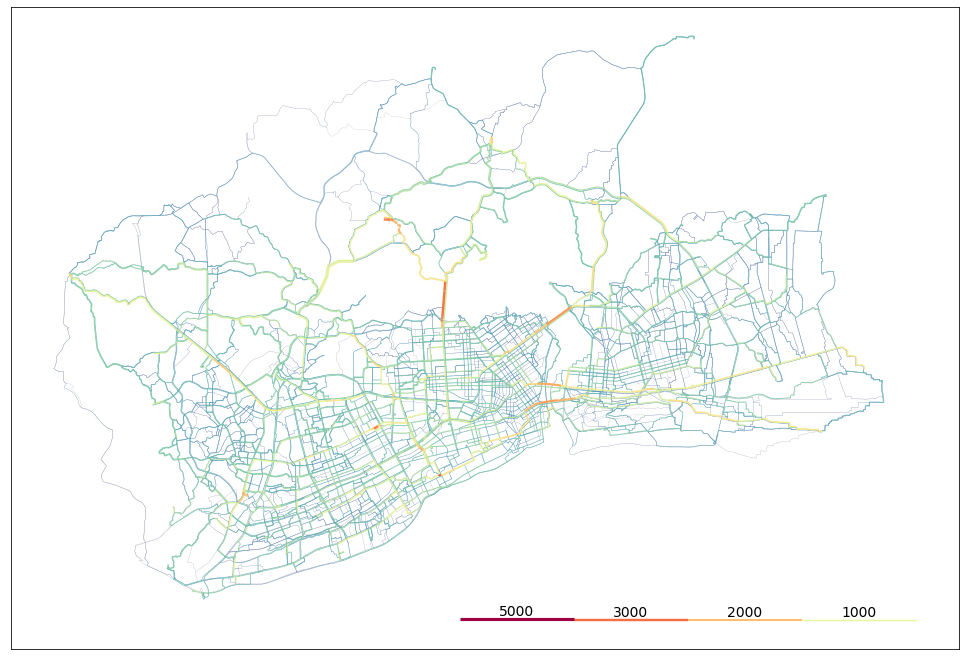

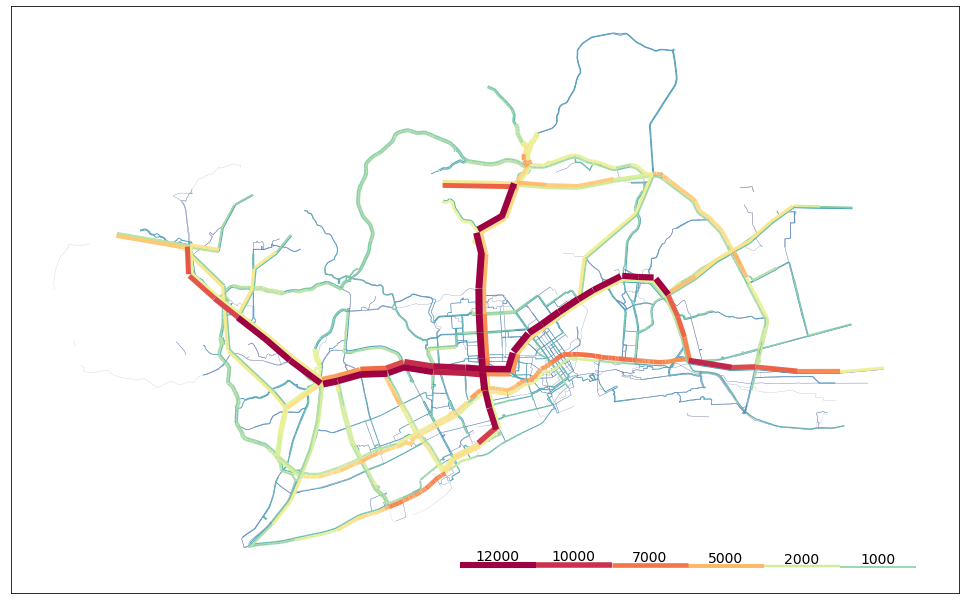

In [76]:
if manual:
    import matplotlib.pyplot as plt
    from syspy.syspy_utils import data_visualization as dv
    spectral = list(reversed(
        ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
         '#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']))

    fig, ax = plt.subplots(figsize=[17, 15])
    lv = (5000,3000, 2000, 1000)
    df = sm.road_links
    df['volume'] = df[('volume', 'car')]
    df = df.dropna(subset=['volume'])

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0], legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=100,
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

    lv = (12000,10000, 7000,5000, 2000, 1000)
    fig, ax = plt.subplots(figsize=[17, 15])
    infra_links = sm.links.loc[sm.links.road_length.isnull()]

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    df = pd.concat([infra_links, sm.road_links])
    df['volume'] = df['volume'].fillna(0)
    df = df.loc[df['volume'] > 0]

    plot = dv.bandwidth(
        df, value_column='volume', power=0.5, max_value=lv[0],legend_values=lv,
        legend_length=0.5, label_column='label', max_linewidth_meters=200,
        #geographical_bounds=list(raster_montreal.bounds),
        cmap=spectral,
        label_kwargs={'size':14, 'color':'black'}, ax=ax
    )

In [77]:
sm.pt_los = sm.los.loc[sm.los['route_type'] != 'car']
sm.to_zip(quetzal_path + 'model/' +scenario + '/assigned.zip', omitted_attributes=['pt_los', 'car_los'])

od: 100%|██████████| 35/35 [00:09<00:00,  3.82it/s]              
